In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
from os.path import expanduser
home_dir = expanduser("~")
module_path = home_dir + '/code/modules/'
trained_networks_path = home_dir + '/trained_networks/'
fig_dir = 'figures/'
import sys
sys.path.append(module_path)
import time
import cv2
import datetime
import importlib
import random
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from operator import itemgetter
from keras.models import load_model

%load_ext autoreload
%autoreload 1
%aimport distance_metrics
%aimport data_processing
%aimport plotting
# %aimport pso
%aimport pso_parallel_training_queue
from distance_metrics import minkowski_distance
from data_processing import *
from plotting import *
# from pso import *
from pso_parallel_training_queue import *

np.random.seed(999)
random.seed(999)

Using TensorFlow backend.


#### Set plot variables

In [ ]:
### Standard plots
model_name = '6x6_tanh_xi10_loss_point9_cutoff_no_empty_bin_punish_nbin_weighted_loss'
mode_of_progress = 'validation' # 'training', 'validation'

data_type = 'val' # 'train', 'val, 'test'
iteration = '691'

plot_full_range = True

model = load_model('trained_networks/{}/{}_best/iter_{}.h5'.format(model_name, mode_of_progress, iteration))
training_data_dict = pickle.load(open('trained_networks/{}/{}_best/training_data_dict.p'.format(model_name, mode_of_progress), 'rb'))

predicted_points = predict_points(model, training_data_dict, mode=data_type, original_units=False)
title = 'Iteration {}, best {} weights, {} data points shown'.format(iteration, mode_of_progress, data_type)

#### Get reinforcement learning plots

In [ ]:
fig858 = get_smf_ssfr_fq_plot(model, training_data_dict, galaxies=None, title=title, data_type=data_type, full_range=True)

In [ ]:
fig73 = get_ssfr_plot(model, training_data_dict, unit_dict, galaxies=None, title=None, data_type=data_type, full_range=plot_full_range)
fig55 = get_smf_plot(model, training_data_dict, unit_dict, galaxies=None, title=None, data_type=data_type, full_range=plot_full_range)
fig33 = get_fq_plot(model, training_data_dict, unit_dict, galaxies=None, title=None, data_type=data_type, full_range=plot_full_range)

In [ ]:
fig73.savefig(fig_dir + 'ssfr_plot_3_loss_func_4x4_400_iters_Z00.png', bbox_inches = 'tight')
fig55.savefig(fig_dir + 'smf_plot_3_loss_func_4x4_400_iters_Z00.png', bbox_inches = 'tight')
fig33.savefig(fig_dir + 'fq_plot_3_loss_func_4x4_400_iters_Z00.png', bbox_inches = 'tight')

#### Get standard pictures

In [ ]:
fig1 = get_pred_vs_real_scatterplot(model, training_data_dict, unit_dict, data_keys, 'Stellar_mass', pso=True, title=title, data_type=mode,
                                   predicted_points = predicted_points, galaxies=galaxies)

fig2 = get_real_vs_pred_boxplot(model, training_data_dict, unit_dict, data_keys, pso=True, predicted_feat = 'Stellar_mass', 
                                binning_feat = 'Halo_mass', title=title, data_type=mode,
                                predicted_points = predicted_points)

In [ ]:
fig3 = get_halo_stellar_mass_plots(model, training_data_dict, no_true_plots=True, title=title, y_max = None, y_min = None,
                                    x_min = None, x_max = None, data_type=data_type, predicted_points = predicted_points)

fig4 = get_stellar_mass_sfr_plots(model, training_data_dict, no_true_plots=True, title=title, y_max = None, y_min = None,
                                    x_min = None, x_max = None, data_type=data_type, predicted_points = predicted_points)

In [ ]:
fig3.savefig(fig_dir + 'halo_stellar_mass_plot_6x6_tanh_xi10_loss_point9_cutoff_no_empty_bin_punish_nbin_weighted_loss.png', bbox_inches = 'tight')
fig4.savefig(fig_dir + 'stellar_mass_sfr_plot_6x6_tanh_xi10_loss_point9_cutoff_no_empty_bin_punish_nbin_weighted_loss.png', bbox_inches = 'tight')

In [ ]:
fig5 = get_real_vs_pred_boxplot(model, training_data_dict, unit_dict, data_keys, pso=True, predicted_feat = 'SFR', 
                                binning_feat = 'Stellar_mass', title=title, data_type=mode,
                                predicted_points = predicted_points)
plt.show

In [ ]:
fig6 = get_real_vs_pred_same_fig(model, training_data_dict, unit_dict, x_axis_feature='Halo_mass', 
                                 y_axis_feature = 'Stellar_mass', pso=True, title=title, data_type=mode, marker_size=20, predicted_points=predicted_points,
                                 y_min=None, y_max=None, x_min=None, x_max=None)
# fig7 = get_real_vs_pred_same_fig(model, training_data_dict, unit_dict, x_axis_feature='Stellar_mass', 
#                                  y_axis_feature = 'SFR', pso=True, title=title, data_type=mode, marker_size=20,
#                                  y_min=None, y_max=None, x_min=None, x_max=None)
plt.show

In [ ]:
fig6.savefig(fig_dir + 'proof_of_concept_3x3_net_one_output_no_weighing.png', bbox_inches = 'tight')

##### Create progress figures and movies

In [ ]:
model_name = 'lin_loss_func_slope_10_point9_cutoff_empty_bin_punish'

modes_of_progress = ['validation', 'training'] # 'training', 'validation'
data_types = ['val', 'train']

plot_types = ['smf', 'ssfr', 'fq']

fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
frame_rate = 1

for mode_of_progress, data_type in zip(modes_of_progress, data_types):
    
    model_dir = 'trained_networks/{}/{}_best/'.format(model_name, mode_of_progress)
    model_fig_dir = 'trained_networks/{}/figures_{}_weights/{}_data/'.format(model_name, mode_of_progress, data_type)

    model_list = []
    for file in os.listdir(model_dir):
        if file == 'training_data_dict.p':
            training_data_dict_model = pickle.load(open(model_dir + file, 'rb'))
        else:
            nr = file[5:-3]
            model_list.append([file, int(nr)])

    model_list.sort(key=itemgetter(1))

    for model_file, iteration in model_list:
        model = load_model(model_dir + model_file)

        title = 'Iteration {}, best {} weights, {} data points shown'.format(iteration, mode_of_progress, data_type)
        if 'fq' in plot_types:
            fq_file_path = model_fig_dir + 'fq/' + 'iteration_{}.png'.format(iteration)
            get_fq_plot(model, training_data_dict_model, galaxies=None, title=title, data_type=data_type, full_range=True, save=True, file_path=fq_file_path)
            
        if 'smf' in plot_types:
            smf_file_path = model_fig_dir + 'smf/' + 'iteration_{}.png'.format(iteration)
            get_smf_plot(model, training_data_dict_model, galaxies=None, title=title, data_type=data_type, full_range=True, save=True, file_path=smf_file_path)
            
        if 'ssfr' in plot_types:
            ssfr_file_path = model_fig_dir + 'ssfr/' + 'iteration_{}.png'.format(iteration)
            get_ssfr_plot(model, training_data_dict_model, galaxies=None, title=title, data_type=data_type, full_range=True, save=True, file_path=ssfr_file_path)
            
    for plot_type in plot_types:
        image_folder = 'trained_networks/{}/figures_{}_weights/{}_data/{}/'.format(model_name, weights, data_type, plot_type)
        video_path = image_folder + 'progress_video.avi'

        images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
        images_with_nrs = []
        for image in images:
            number = image.split('_')
            number = number[-1][:-4]
            images_with_nrs.append([image, int(number)])

        images_with_nrs.sort(key=itemgetter(1))

        images = [image_folder + items[0] for items in images_with_nrs]

        frame = cv2.imread(images[0])
        height, width, layers = frame.shape

        video = cv2.VideoWriter(video_path, fourcc, frame_rate, (width,height))

        for image in images:
            img = cv2.imread(image)
            video.write(img)

        video.release()
        cv2.destroyAllWindows()
    

#### Movie with all three loss conditions in same fig

In [10]:
model_name = '6x6_all-points_redshifts00_tanh_Halo_mass-Halo_mass_peak-Scale_peak_mass-Scale_half_mass-Halo_growth_rate_to_Stellar_mass-SFR_test_score5.48e-04'
training_material = 'mock_observations' # 'mock_observations', 'real_observations'
training = 'backprop_and_pso_trained' # 'pso_trained', 'backprop_trained', 'backprop_and_pso_trained'
mode_of_progress = 'validation' # 'training', 'validation'
data_type = 'val' # 'train', 'val'
produce_images = False

fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
frame_rate = 1

# trained_networks/pso_trained/mock_observations/6x6_2.9e+04points_redshifts00_tanh_exp30_loss_minFilledBinFrac000_fq-ssfr-smf-shm_weights_0-1-1-2/validation_best/

model_dir = '{}/trained_networks/{}/{}/{}/'.format(home_dir, training, training_material, model_name)
folder = '{}figures_{}_weights/{}_data/all_losses/'.format(model_dir, mode_of_progress, data_type)

dirs = list(os.walk(folder))
print(dirs[0])

('/home/magnus/trained_networks/backprop_and_pso_trained/mock_observations/6x6_all-points_redshifts00_tanh_Halo_mass-Halo_mass_peak-Scale_peak_mass-Scale_half_mass-Halo_growth_rate_to_Stellar_mass-SFR_test_score5.48e-04/figures_validation_weights/val_data/all_losses/', ['Z00'], [])


In [14]:
model_name = '6x6_all-points_redshifts00_tanh_Halo_mass-Halo_mass_peak-Scale_peak_mass-Scale_half_mass-Halo_growth_rate_to_Stellar_mass-SFR_test_score5.48e-04'
training_material = 'mock_observations' # 'mock_observations', 'real_observations'
training = 'backprop_and_pso_trained' # 'pso_trained', 'backprop_trained', 'backprop_and_pso_trained'
modes_of_progress = ['validation'] # 'training', 'validation'
data_types = ['val'] # 'train', 'val'
produce_images = False

fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
frame_rate = 1

# trained_networks/pso_trained/mock_observations/6x6_2.9e+04points_redshifts00_tanh_exp30_loss_minFilledBinFrac000_fq-ssfr-smf-shm_weights_0-1-1-2/validation_best/

model_dir = '{}/trained_networks/{}/{}/{}/'.format(home_dir, training, training_material, model_name)

for mode_of_progress, data_type in zip(modes_of_progress, data_types):
    mode_of_progress_networks_dir = '{}{}_best/'.format(model_dir, mode_of_progress)
    model_fig_dir = '{}figures_{}_weights/{}_data/all_losses/'.format(model_dir, mode_of_progress, data_type)
    
    root_path, redshift_dirs, files = list(os.walk(model_fig_dir))[0]
    redshift_paths = [root_path + redshift_dir + '/' for redshift_dir in redshift_dirs]
    for redshift_path in redshift_paths:
    
        if produce_images:

            model_list = []
            for file in os.listdir(redshift_path):
                if file == 'training_data_dict.p':
                    training_data_dict_model = pickle.load(open(mode_of_progress_networks_dir + file, 'rb'))
                else:
                    nr = file[5:-3]
                    model_list.append([file, int(nr)])

            model_list.sort(key=itemgetter(1))

            for model_file, iteration in model_list:
                model = load_model(mode_of_progress_networks_dir + model_file)

                title = 'Iteration {}, best {} weights, {} data points shown'.format(iteration, mode_of_progress, data_type)
                fig_file_path = redshift_path + 'iteration_{}.png'.format(iteration)
                get_smf_ssfr_fq_plot(model, training_data_dict_model, galaxies=None, title=title, data_type=data_type, full_range=True, save=True, file_path=fig_file_path)

        video_path = redshift_path + 'progress_video.avi'

        images = [img for img in os.listdir(redshift_path) if img.endswith(".png")]
        images_with_nrs = []
        for image in images:
            number = image.split('_')
            number = number[-1][:-4]
            images_with_nrs.append([image, int(number)])

        images_with_nrs.sort(key=itemgetter(1))

        images = [redshift_path + items[0] for items in images_with_nrs]

        frame = cv2.imread(images[0])
        height, width, layers = frame.shape

        video = cv2.VideoWriter(video_path, fourcc, frame_rate, (width,height))

        for image in images:
            img = cv2.imread(image)
            video.write(img)

        video.release()
        cv2.destroyAllWindows()

#### Distance between new high scores

In [ ]:
model_name = '6x6_all-points_redshifts00_tanh_Halo_mass-Halo_mass_peak-Scale_peak_mass-Scale_half_mass-Halo_growth_rate_to_Stellar_mass-SFR_test_score5.48e-04'

model_dir = trained_networks_path + 'backprop_and_pso_trained/mock_observations/{}/'.format(model_name)
os.makedirs(os.path.dirname(model_dir + 'swarm_best_distance_moved.p'), exist_ok=True)
distance_dict = pickle.load(open(model_dir + 'swarm_best_distance_moved.p', 'rb'))

print(distance_dict.keys())

fig = plt.figure(figsize=(15,10))
plt.plot(distance_dict['swarm_best_distance_moved_p_point_one'])
plt.plot(distance_dict['swarm_best_distance_moved_p_one'])
plt.plot(distance_dict['swarm_best_distance_moved_p_two'])
plt.plot(distance_dict['swarm_best_distance_moved_p_inf'])
plt.legend(['p = 0.1', 'p = 1', 'p = 2', 'p = inf'], loc='upper right', fontsize='xx-large')
# plt.plot([dist[1][0] for dist in distance_dict['swarm_best_distance_moved_p_point_one']])
plt.yscale('log')

In [ ]:
fig.savefig(fig_dir + '4x4_relu_xi10_loss_point9_cutoff_no_empty_bin_punish.png', bbox_inches = 'tight')

In [ ]:
print(np.array(distance_dict['swarm_best_distance_moved_p_one'][10:])/np.array(distance_dict['swarm_best_distance_moved_p_point_one'][10:]))


#### Interparticle distances

In [15]:
model_name = '6x6_all-points_redshifts00-01-02-05-10-20-30-40-60-80_tanh_Halo_mass-Halo_mass_peak-Scale_peak_mass-Scale_half_mass-Halo_growth_rate-Redshift_to_Stellar_mass-SFR_test_score5.91e-06'

score_hist_path = trained_networks_path + 'backprop_and_pso_trained/mock_observations/{}/score_history.p'.format(model_name)
score_hist_dict = pickle.load(open(score_hist_path, 'rb'))

print(score_hist_dict)

{'iterations_train_best': [0, 12, 33, 34, 34], 'iterations_val_best': [0, 12, 34], 'train_score_history': [2.2433496567732294, 2.0557663850772827, 2.0536014417366597, 1.8959225058209492, 1.7858218732474762], 'val_score_history': [1.9084575549258898, 1.6398519456462164, 1.530985365289254]}


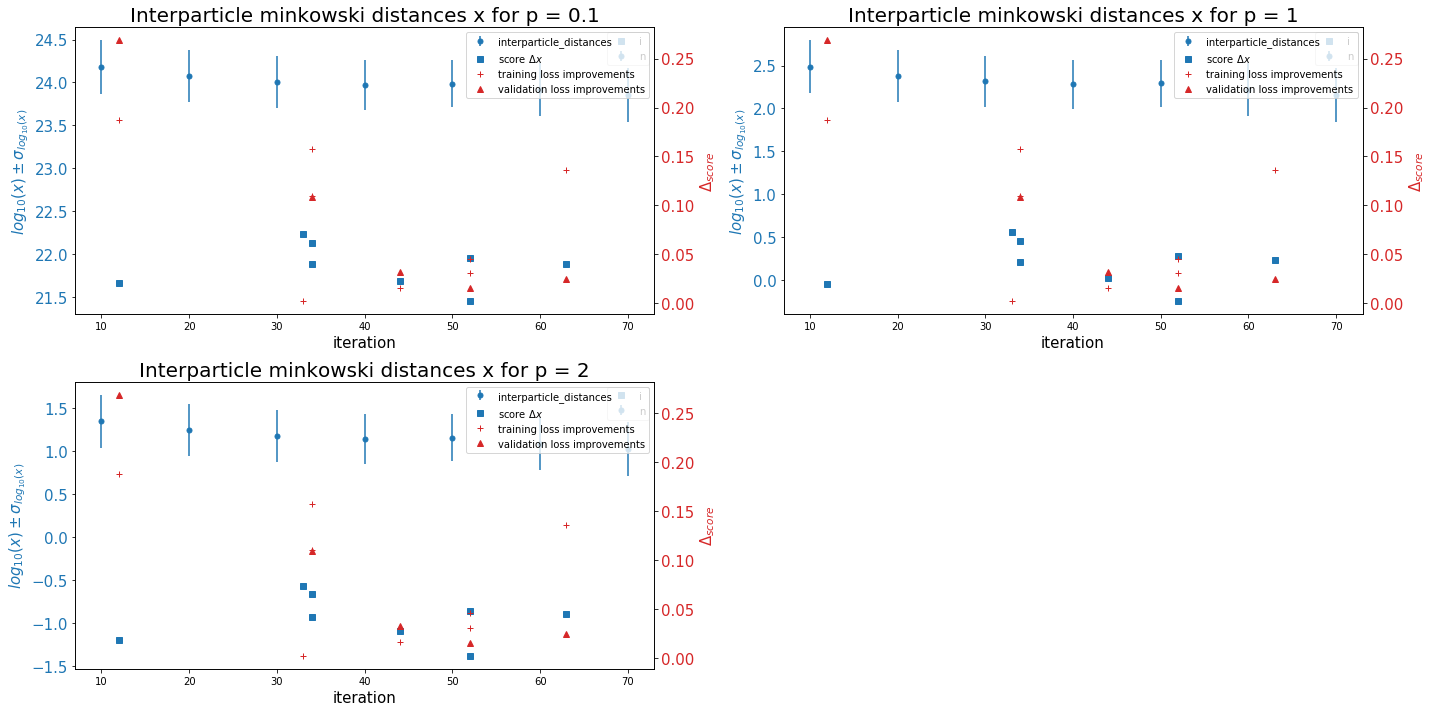

In [59]:
model_name = '6x6_all-points_redshifts00-01-02-05-10-20-30-40-60-80_tanh_Halo_mass-Halo_mass_peak-Scale_peak_mass-Scale_half_mass-Halo_growth_rate-Redshift_to_Stellar_mass-SFR_test_score5.91e-06'
training_material = 'mock_observations' # 'mock_observations', 'real_observations'
training = 'backprop_and_pso_trained' # 'pso_trained', 'backprop_trained', 'backprop_and_pso_trained'
figure_scale = 'linear' # 'linear', 'log', 'symlog', 'logit'
iterations_skipped = 1
distance_color = 'tab:blue'
score_improvements_color = 'tab:red'
part_dist_sym = 'o'
score_dist_sym = 's'
train_score_sym = '+'
val_score_sym = '^'

score_distance_path = trained_networks_path + '{}/{}/{}/swarm_best_distance_moved.p'.format(training, training_material, model_name)
score_distance_dict = pickle.load(open(score_distance_path, 'rb'))
dist_moved_p_point_one = np.log10(score_distance_dict['swarm_best_distance_moved_p_point_one'][1:])
dist_moved_p_one = np.log10(score_distance_dict['swarm_best_distance_moved_p_one'][1:])
dist_moved_p_two = np.log10(score_distance_dict['swarm_best_distance_moved_p_two'][1:])

score_hist_path = trained_networks_path + '{}/{}/{}/score_history.p'.format(training, training_material, model_name)
score_hist_dict = pickle.load(open(score_hist_path, 'rb'))
training_score_improvements = []
validation_score_improvements = []
for i in range(len(score_hist_dict['train_score_history']) - 1):
    training_score_improvements.append(score_hist_dict['train_score_history'][i] - score_hist_dict['train_score_history'][i+1])
for i in range(len(score_hist_dict['val_score_history']) - 1):
    validation_score_improvements.append(score_hist_dict['val_score_history'][i] - score_hist_dict['val_score_history'][i+1])

interparticle_dict_dir = trained_networks_path + '{}/{}/{}/interparticle_distances/'.format(training, training_material, model_name)

dict_list = []
for file in os.listdir(interparticle_dict_dir):
    nr = file[5:-2]
    dict_list.append([file, int(nr)])

dict_list.sort(key=itemgetter(1))

p_point_one_list = []
p_one_list = []
p_two_list = []
iteration_list = []

for dict_file, iteration in dict_list[iterations_skipped:]:
    interparticle_distance_dict = pickle.load(open(interparticle_dict_dir + dict_file, 'rb'))
    
    p_point_one = []
    p_one = []
    p_two = []
    
    for i in range(np.shape(interparticle_distance_dict['p_point_one'])[0]):
        for j in range(i+1, np.shape(interparticle_distance_dict['p_point_one'])[1]):
            p_point_one.append(interparticle_distance_dict['p_point_one'][i,j])
    for i in range(np.shape(interparticle_distance_dict['p_one'])[0]):
        for j in range(i+1, np.shape(interparticle_distance_dict['p_one'])[1]):
            p_one.append(interparticle_distance_dict['p_one'][i,j])
    for i in range(np.shape(interparticle_distance_dict['p_two'])[0]):
        for j in range(i+1, np.shape(interparticle_distance_dict['p_two'])[1]):
            p_two.append(interparticle_distance_dict['p_two'][i,j])
            
    p_point_one_list.append(np.log10(p_point_one))
    p_one_list.append(np.log10(p_one))
    p_two_list.append(np.log10(p_two))
    
    iteration_list.append(iteration)
    
mean_dist_p_point_one = []
std_p_point_one = []
mean_dist_p_one = []
std_p_one = []
mean_dist_p_two = []
std_p_two = []

for i_iteration, iteration in enumerate(iteration_list):
    
    mean_dist_p_point_one.append(np.mean(p_point_one_list[i_iteration]))
    mean_dist_p_one.append(np.mean(p_one_list[i_iteration]))
    mean_dist_p_two.append(np.mean(p_two_list[i_iteration]))
    
    if figure_scale == 'log':
        std_p_point_one.append(np.std(np.log(p_point_one_list[i_iteration])))
        std_p_one.append(np.std(np.log(p_one_list[i_iteration])))
        std_p_two.append(np.std(np.log(p_two_list[i_iteration])))
    else:
        std_p_point_one.append(np.std(p_point_one_list[i_iteration]))
        std_p_one.append(np.std(p_one_list[i_iteration]))
        std_p_two.append(np.std(p_two_list[i_iteration]))
        
interparticle_plot_pairs = [[mean_dist_p_point_one, std_p_point_one], [mean_dist_p_one, std_p_one], [mean_dist_p_two, std_p_two]]
score_dist_plots = [dist_moved_p_point_one, dist_moved_p_one, dist_moved_p_two]
titles = ['Interparticle minkowski distances x for p = 0.1', 'Interparticle minkowski distances x for p = 1', 'Interparticle minkowski distances x for p = 2']
legend_entries = ['interparticle_distances', 'score $\Delta x$', 'training loss improvements', 'validation loss improvements']
x_label = 'iteration'
y_label_interparticle_dists = '$log_{10}(x)\pm\sigma_{log_{10}(x)}$'
y_label_scores = '$\Delta_{score}$'
    
fig_dist = plt.figure(figsize=(20,10))

for i, (mean_dist, stds) in enumerate(interparticle_plot_pairs):
    ax1 = plt.subplot(2,2,i+1)
    interpart_dist_line = ax1.errorbar(iteration_list, mean_dist, yerr=stds, fmt=part_dist_sym, markersize=5, color=distance_color)
    score_dist_line, = ax1.plot(score_hist_dict['iterations_train_best'][1:], score_dist_plots[i], score_dist_sym, color=distance_color)
    ax1.set_yscale(figure_scale)
    ax1.tick_params(axis='y', labelcolor=distance_color, labelsize=15)
    ax1.set_ylabel(y_label_interparticle_dists, color=distance_color, fontsize=15)
    ax1.set_xlabel(x_label, fontsize=15)
    plt.legend(legend_entries[0])

    ax2 = ax1.twinx()
    train_imp_line, = ax2.plot(score_hist_dict['iterations_train_best'][1:], training_score_improvements, train_score_sym, color=score_improvements_color)
    val_imp_line, = ax2.plot(score_hist_dict['iterations_val_best'][1:], validation_score_improvements, val_score_sym, color=score_improvements_color)
    ax2.tick_params(axis='y', labelcolor=score_improvements_color, labelsize=15)
    ax2.set_ylabel(y_label_scores, color=score_improvements_color, fontsize=15)
    
    plt.legend([interpart_dist_line, score_dist_line, train_imp_line, val_imp_line], legend_entries)
    
    plt.title(titles[i], fontsize=20)
    
plt.tight_layout()
plt.show()

In [ ]:
os.makedirs(os.path.dirname(model_dir + 'interparticle_distances/iter_{}.p'), exist_ok=True)
distance_dict = pickle.load(open(model_dir + 'interparticle_distances.p', 'rb'))


print(distance_dict.keys())
print(distance_dict['p_point_one'])

fig = plt.figure(figsize=(15,10))
plt.plot(distance_dict['p_point_one'], 'bo')
plt.plot(distance_dict['p_one'], 'rx')
plt.plot(distance_dict['p_two'], 'g.')
plt.legend(['p = 0.1', 'p = 1', 'p = 2'], loc='upper right', fontsize='xx-large')
# plt.plot([dist[1][0] for dist in distance_dict['swarm_best_distance_moved_p_point_one']])
plt.yscale('log')

In [ ]:
a = [[1,2],[3,4],[10,2]]
b = minkowski_distance(a, p=20)
print(b)

In [ ]:
np.power(0, 9)

### Non parallel PSO

In [ ]:
mode = 'train'
network.pso_swarm.set_best_weights('train')
norm_score = network.pso_swarm.evaluate_model(mode)
tot_score = norm_score
model = network.model
title = 'Inputs: %s\ntest mse %.3e, %s data' % (', '.join(input_features), tot_score, mode)

fig1 = get_pred_vs_real_scatterplot(model, training_data_dict, unit_dict, data_keys, 'SFR', title=title, mode=mode)
fig2 = get_real_vs_pred_boxplot(model, training_data_dict, unit_dict, data_keys, predicted_feat = 'Stellar_mass', 
                                binning_feat = 'Halo_mass', title=title, mode=mode)
fig3 = get_scatter_comparison_plots(model, training_data_dict, unit_dict, x_axis_feature = 'Halo_mass', 
                                    y_axis_feature = 'Stellar_mass', title=title, y_max = None, y_min = None,
                                    x_min = None, x_max = None, mode=mode)
fig4 = get_real_vs_pred_boxplot(model, training_data_dict, unit_dict, data_keys, 'SFR', 
                                binning_feat = 'Stellar_mass', title=title, mode=mode)
fig5 = get_scatter_comparison_plots(model, training_data_dict, unit_dict, x_axis_feature = 'Halo_mass', 
                                    y_axis_feature = 'SFR', title=title, y_max = 10, y_min = None,
                                    x_min = None, x_max = None, mode=mode)

plt.show

#### Train new network

In [ ]:
### General parameters
total_set_size = 2.9e4 # how many examples will be used for training+validation+testing
train_size = 2e4
val_size = .5e4
test_size = .4e4
input_features = ['Halo_mass', 'Halo_mass_peak', 'Scale_peak_mass', 'Scale_half_mass', 'Halo_growth_rate']#, 'Redshift']
output_features = ['Stellar_mass', 'SFR']
redshifts = [0]#,.1,.2,.5,1,2,3,4,6,8]
same_n_points_per_redshift = False # if using the smf in the objective function, must be false!
outputs_to_weigh = ['Stellar_mass']
weigh_by_redshift = True

reinforcement_learning = True
real_observations = False

verbatim = True

network_name = 'testing2'
# network_name = '{}'.format(datetime.datetime.now().strftime("%Y-%m-%d"))
save_all_nets = True

### Network parameters
nr_hidden_layers = 4
activation_function = 'tanh'
output_activation = {'SFR': None, 'Stellar_mass': None}
nr_neurons_per_layer = 4
regularisation_strength = 1e-2
std_penalty = False
norm = {'input': 'zero_mean_unit_std',
        'output': 'zero_mean_unit_std'} # 'none',   'zero_mean_unit_std',   'zero_to_one'

### PSO parameters
nr_processes = 30
nr_iterations = 1000
min_std_tol = 0.01                # minimum allowed std for any parameter
pso_param_dict = {
    'nr_particles': 3 * nr_processes,
    'inertia_weight_start': 1.4,
    'inertia_weight_min': 0.3,
    'exploration_iters': 600,
    'patience': 10000,
    'patience_parameter': 'train',
    'restart_check_interval': 200
}

os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Load and preprocess the data

In [ ]:
# load the selected galaxyfile
galaxies, data_keys, unit_dict = load_galfiles(redshifts=redshifts, equal_numbers=same_n_points_per_redshift)
    
# prepare the training data
training_data_dict = divide_train_data(galaxies, data_keys, input_features, output_features, redshifts, weigh_by_redshift, outputs_to_weigh,
                                       int(total_set_size), train_size=int(train_size), val_size=int(val_size), test_size=int(test_size), pso=True)
training_data_dict = normalise_data(training_data_dict, norm, pso=True)

# Create a new network

In [ ]:
network = Feed_Forward_Neural_Network(nr_hidden_layers, nr_neurons_per_layer, input_features, output_features, 
                                      activation_function, output_activation, regularisation_strength, network_name)
network.setup_pso(pso_param_dict, reinf_learning=reinforcement_learning, real_observations=real_observations, nr_processes=nr_processes)
network.train_pso(nr_iterations, training_data_dict, std_penalty=std_penalty, verbatim=verbatim, save_all_networks=save_all_nets)